In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model import DenseNetFE, Seq2Seq, Decoder

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [11]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_data_loader, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR, PAD_CHAR
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy, HandcraftFeature

In [9]:
config = {
        'batch_size': 32,
        'scale_height': 128,
        'hidden_size': 256,
        'attn_size': 256,
        'max_length': 10,
        'n_epochs_decrease_lr': 15,
        'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
        'end_learning_rate': 1e-11,
        'depth': 4,
        'n_blocks': 3,
        'growth_rate': 96,
        'max_epochs': 50,
        'weight_decay': 0,
    }

In [6]:
MAX_LENGTH = config['max_length']
# CKPT_DIR = './ckpt'
CKPT_DIR = './runs/09-02-2020_10-43-27_s2s/weights/'

In [7]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [12]:
image_transform = transforms.Compose([
        ScaleImageByHeight(config['scale_height']),
        HandcraftFeature(),
        transforms.ToTensor(),
    ])

In [13]:
test_loader = get_data_loader('test', config['batch_size'], transform=image_transform)
# test_loader = get_data_loader('train', config['batch_size'], transform=image_transform)

In [14]:
def make_model():
    fe = DenseNetFE(config['depth'], config['n_blocks'], config['growth_rate'])
    decoder = Decoder(fe.n_features, config['hidden_size'], vocab_size, config['attn_size'])
    model = Seq2Seq(fe, vocab_size, config['hidden_size'], config['attn_size'])
    return model
model = make_model()

In [15]:
model.load_state_dict(info['model'])

<All keys matched successfully>

In [16]:
model = model.to(device);

In [17]:
model.eval();

In [18]:
test_iter = iter(test_loader)

In [19]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [20]:
imgs.size()

torch.Size([32, 3, 128, 396])

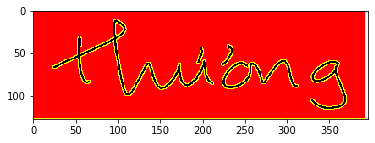

In [21]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [22]:
targets.size()

torch.Size([8, 32, 1])

In [23]:
[''.join([int2char[x.item()] for x in targets[:,i].squeeze()]) for i in range(targets.size(1))]

['<start>thương<end>',
 '<start>huyện<end><pad>',
 '<start>Thành<end><pad>',
 '<start>người<end><pad>',
 '<start>tình<end><pad><pad>',
 '<start>Tiên<end><pad><pad>',
 '<start>Long<end><pad><pad>',
 '<start>Tiên<end><pad><pad>',
 '<start>Long<end><pad><pad>',
 '<start>Châu<end><pad><pad>',
 '<start>Ông<end><pad><pad><pad>',
 '<start>già<end><pad><pad><pad>',
 '<start>năm<end><pad><pad><pad>',
 '<start>làm<end><pad><pad><pad>',
 '<start>nhà<end><pad><pad><pad>',
 '<start>Tôi<end><pad><pad><pad>',
 '<start>gặp<end><pad><pad><pad>',
 '<start>ông<end><pad><pad><pad>',
 '<start>Văn<end><pad><pad><pad>',
 '<start>Tám<end><pad><pad><pad>',
 '<start>ngụ<end><pad><pad><pad>',
 '<start>Bến<end><pad><pad><pad>',
 '<start>Tre<end><pad><pad><pad>',
 '<start>30<end><pad><pad><pad><pad>',
 '<start>Lê<end><pad><pad><pad><pad>',
 '<start>On<end><pad><pad><pad><pad>',
 '<start>On<end><pad><pad><pad><pad>',
 '<start>ấp<end><pad><pad><pad><pad>',
 '<start>xã<end><pad><pad><pad><pad>',
 '<start>là<end><pad>

In [24]:
imgs.size()

torch.Size([32, 3, 128, 396])

In [25]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    targets_onehot = targets_onehot.to(device)
    outputs, weights = model.greedy(imgs, targets_onehot)

In [26]:
outputs.size()

torch.Size([10, 32, 150])

In [27]:
_, index = outputs.topk(1, -1)

In [28]:
index.size()

torch.Size([10, 32, 1])

In [29]:
predicts = index.squeeze(0).transpose(0, 1) # [B, T]
predicts

tensor([[[ 57],
         [ 45],
         [ 95],
         [ 38],
         [ 51],
         [ 44],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 45],
         [ 58],
         [ 61],
         [121],
         [ 51],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 32],
         [ 45],
         [ 69],
         [ 51],
         [ 45],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 51],
         [ 44],
         [ 95],
         [134],
         [ 46],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 57],
         [ 76],
         [ 51],
         [ 45],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 32],
         [ 46],
         [ 75],
         [ 51],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10],
         [ 10]],

        [[ 24],
         [ 5

In [30]:
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])
predicts_str

[['t', 'h', 'ư', 'a', 'n', 'g', '<end>'],
 ['h', 'u', 'y', 'ệ', 'n', '<end>'],
 ['T', 'h', 'à', 'n', 'h', '<end>'],
 ['n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['t', 'ì', 'n', 'h', '<end>'],
 ['T', 'i', 'ê', 'n', '<end>'],
 ['L', 'o', 'n', 'g', '<end>'],
 ['T', 'i', 'ê', 'n', '<end>'],
 ['l', 'o', 'n', 'g', '<end>'],
 ['a', 'r', 'â', 'u', '<end>'],
 ['Ô', 'n', 'g', '<end>'],
 ['g', 'i', 'à', '<end>'],
 ['n', 'ă', 'm', '<end>'],
 ['l', 'à', 'm', '<end>'],
 ['n', 'h', 'à', '<end>'],
 ['T', 'ô', 'i', '<end>'],
 ['g', 'ặ', 'p', '<end>'],
 ['ô', 'n', 'g', '<end>'],
 ['V', 'ă', 'n', '<end>'],
 ['T', 'á', 'm', '<end>'],
 ['n', 'g', 'ụ', '<end>'],
 ['B', 'ế', 'n', '<end>'],
 ['T', 'r', 'e', '<end>'],
 ['3', '0', '<end>'],
 ['L', 'ê', '<end>'],
 ['C', 'n', '<end>'],
 ['0', 'N', '<end>'],
 ['ấ', 'p', '<end>'],
 ['x', 'ã', '<end>'],
 ['l', 'à', '<end>'],
 ['ở', '<end>'],
 ['1', '<end>']]

# Visualize a sample

In [ ]:
sample_index = 1
sample_image, sample_predict = imgs[sample_index], predicts_str[sample_index]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)
img_rows, img_cols = imgs.size()[-2:]

for i, axes in enumerate(axeses.ravel()):
    weight_numpy = weights.cpu().numpy()[i,sample_index,:].squeeze()
    weight_numpy = weight_numpy.reshape(round(img_rows/16), round(img_cols/16)) # 16 is factor that DenseNet reduce the original image size
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.4
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend, cmap='gray')
plt.plot();

# Calc CER, WER on the test set

## CER

In [32]:
import editdistance as ed

In [33]:
log_test = open('./log_test.txt', 'w+')

In [34]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

# t = tqdm(test_loader)
t = test_loader
with torch.no_grad():
    for i, (imgs, targets, targets_onehot, lengths) in enumerate(t):
        print(f'[{i}]/[{len(t)}]', file=log_test)
        log_test.flush()
        batch_size = imgs.size(0)
        
        imgs = imgs.to(device)
        targets_onehot = targets_onehot.to(device)
        outputs, weights = model.forward(imgs, targets_onehot)
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index-1]) # ignore <end>

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[1:eos_index-1]) #ignore <start< and <end>
        
        assert len(predicts_str) == len(targets_str)
        for j in range(len(predicts_str)):
            CE += ed.distance(predicts_str[j], targets_str[j])
        total_characters += lengths.sum().item()
        
        for j in range(len(predicts_str)):
            if not np.array_equal(np.array(predicts_str[j]), np.array(targets_str[j])):
                WE += 1
                print(f'Batch {i} - sample {j}: "{predicts_str[j]}"/"{targets_str[j]}"')
        total_words += len(predicts_str)
        
#         t.update()

Batch 0 - sample 0: "['t', 'h', 'ư', 'a', 'n', 'g']"/"['t', 'h', 'ư', 'ơ', 'n', 'g']"
Batch 0 - sample 8: "['l', 'o', 'n', 'g']"/"['L', 'o', 'n', 'g']"
Batch 0 - sample 9: "['a', 'r', 'â', 'u']"/"['C', 'h', 'â', 'u']"
Batch 0 - sample 25: "['C', 'n']"/"['O', 'n']"
Batch 0 - sample 26: "['0', 'N']"/"['O', 'n']"
Batch 1 - sample 7: "['l', 'h', 'ă', 'n']"/"['k', 'h', 'ă', 'n']"
Batch 1 - sample 10: "['n', 'ì', 'n', 'h']"/"['m', 'ì', 'n', 'h']"
Batch 1 - sample 15: "['b', 'o', 'o']"/"['6', '0', '0']"
Batch 1 - sample 18: "['d', 'h', 'o']"/"['c', 'h', 'o']"
Batch 1 - sample 19: "['k', 'h', 'ó']"/"['K', 'h', 'ó']"
Batch 1 - sample 25: "['C', 'à', 'n']"/"['l', 'à', 'm']"
Batch 1 - sample 27: "['ô', 'n', 'g']"/"['Ô', 'n', 'g']"
Batch 2 - sample 0: "['t', 'r', 'ư', 'ơ', 'n']"/"['t', 'h', 'ư', 'ơ', 'n', 'g']"
Batch 2 - sample 8: "['k', 'i', 'ể', 'm']"/"['k', 'i', 'ế', 'm']"
Batch 2 - sample 10: "['L', 'à', 'm']"/"['l', 'à', 'm']"
Batch 2 - sample 14: "['C', 'à', 'm']"/"['L', 'à', 'm']"
Batch 2 -

In [35]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER, file=log_test)
print('WER', WER, file=log_test)
log_test.flush()

In [36]:
log_test.close()

In [37]:
print(CE, total_characters, CER)

8447 133729 0.06316505769130107


In [38]:
print(WE, total_words, WER)

6329 25115 0.25200079633685046
